**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import requests
import os
from google.colab import userdata

**hiding API key**

In [2]:
tng_api_key = userdata.get('TNG_API_KEY')
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":tng_api_key}

In [3]:
def get(path, params=None):
    headers = {"api-key":tng_api_key}
    r = requests.get(path, params=params, headers=headers)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers: #not only json
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [4]:
r = get(baseUrl)
r.keys()

dict_keys(['simulations'])

In [5]:
r['simulations'][0]

{'name': 'Illustris-1',
 'num_snapshots': 134,
 'url': 'http://www.tng-project.org/api/Illustris-1/'}

In [6]:
for simulation in r['simulations']: #only get TNG50
    if simulation['name'] == 'TNG50-1':
        url = simulation['url']
        break

In [7]:
tng50 = get(url)
tng50.keys()

dict_keys(['name', 'description', 'name_alt', 'boxsize', 'z_start', 'z_final', 'cosmology', 'omega_0', 'omega_L', 'omega_B', 'hubble', 'physics_model', 'has_cooling', 'has_starformation', 'has_winds', 'has_blackholes', 'mass_gas', 'mass_dm', 'softening_dm_comoving', 'softening_stars_comoving', 'softening_blackholes_comoving', 'softening_gas_comoving', 'softening_dm_max_phys', 'softening_stars_max_phys', 'softening_blackholes_max_phys', 'softening_gas_max_phys', 'softening_gas_factor', 'softening_gas_comoving_min', 'num_dm', 'num_tr_mc', 'num_tr_vel', 'longids', 'is_uniform', 'is_zoom', 'is_subbox', 'num_files_snapshot', 'num_files_groupcat', 'num_files_rockstar', 'num_files_lhalotree', 'num_files_sublink', 'num_files_ctrees', 'filesize_lhalotree', 'filesize_sublink', 'filesize_ctrees', 'filesize_ics', 'filesize_simulation', 'has_fof', 'has_subfind', 'has_rockstar', 'has_lhalotree', 'has_sublink', 'has_ctrees', 'permission_required', 'num_snapshots', 'url', 'parent_simulation', 'child_s

In [8]:
url = 'http://www.tng-project.org/api/TNG50-1/snapshots/z=1.8/' #find the snapshot
snapshot = get(url)
snapshot['number'], snapshot['redshift']

(35, 1.82268925262035)

In [9]:
sub_url = f"http://www.tng-project.org/api/TNG50-1/snapshots/{snapshot['number']}/subhalos/0/" #put in 0 because I don't know the actual subhalo
subhalo = get(sub_url)
subhalo.keys() #keep in mind to look into "bhmdot" and "sfr" for future research

dict_keys(['snap', 'id', 'bhmdot', 'cm_x', 'cm_y', 'cm_z', 'gasmetallicity', 'gasmetallicityhalfrad', 'gasmetallicitymaxrad', 'gasmetallicitysfr', 'gasmetallicitysfrweighted', 'pos_x', 'pos_y', 'pos_z', 'halfmassrad', 'halfmassrad_gas', 'halfmassrad_dm', 'halfmassrad_stars', 'halfmassrad_bhs', 'len', 'len_gas', 'len_dm', 'len_stars', 'len_bhs', 'mass', 'mass_gas', 'mass_dm', 'mass_stars', 'mass_bhs', 'massinhalfrad', 'massinhalfrad_gas', 'massinhalfrad_dm', 'massinhalfrad_stars', 'massinhalfrad_bhs', 'massinmaxrad', 'massinmaxrad_gas', 'massinmaxrad_dm', 'massinmaxrad_stars', 'massinmaxrad_bhs', 'massinrad', 'massinrad_gas', 'massinrad_dm', 'massinrad_stars', 'massinrad_bhs', 'sfr', 'sfrinhalfrad', 'sfrinmaxrad', 'sfrinrad', 'spin_x', 'spin_y', 'spin_z', 'starmetallicity', 'starmetallicityhalfrad', 'starmetallicitymaxrad', 'stellarphotometrics_u', 'stellarphotometrics_b', 'stellarphotometrics_v', 'stellarphotometrics_k', 'stellarphotometrics_g', 'stellarphotometrics_r', 'stellarphotome

In [10]:
cutout_request = {'gas':'Coordinates,Masses,InternalEnergy,ElectronAbundance'} #only get this specific info
cutout = get(sub_url+"cutout.hdf5", cutout_request)

In [11]:
with h5py.File(cutout,'r') as f:
    x = f['PartType0']['Coordinates'][:,0] - subhalo['pos_x']
    y = f['PartType0']['Coordinates'][:,1] - subhalo['pos_y']
    dens = np.log10(f['PartType0']['Masses'][:])
    u = f['PartType0']['InternalEnergy'][:]
    xe = f['PartType0']['ElectronAbundance'][:]


In [16]:
Xh = 0.76 #hydrogen abundnance            #values for temperature equation
mp = 1.67e-27 #kg
kb = 1.38e-23
gamma = 5/3
unitRatio = 1e10

mu = 4 / (1 + 3*Xh + 4*Xh*xe) * mp
T = (gamma-1)*unitRatio*mu*u/kb

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1091321841.py:2: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta x$ [ckpc/h]')
/tmp/ipython-input-1091321841.py:3: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta y$ [ckpc/h]');


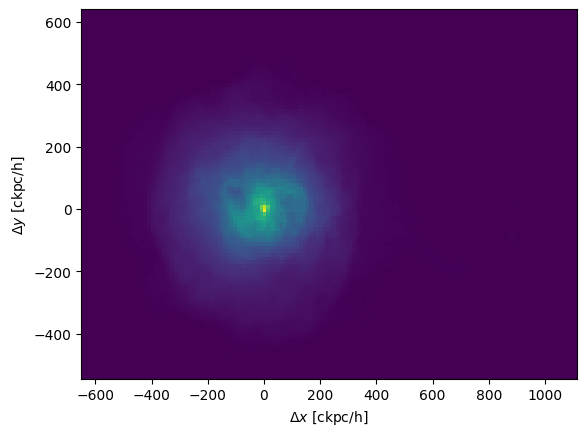

In [17]:
plt.hist2d(x,y,weights=T,bins=[150,100])
plt.xlabel('$\Delta x$ [ckpc/h]')
plt.ylabel('$\Delta y$ [ckpc/h]');